In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.11.375,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell'

In [4]:
from pyspark import SQLContext
#from pyspark.ml.classification import LogisticRegression
from pyspark.ml.image import ImageSchema

#from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *

import pandas as pd
import numpy as np
from sklearn import decomposition
from PIL import Image
from skimage.transform import resize
import io as io
import matplotlib.pyplot as plt
import cv2
import boto3
from matplotlib.image import imread

Matplotlib is building the font cache; this may take a moment.


In [5]:
from keras.applications.resnet import preprocess_input
from keras.applications.resnet import ResNet50

In [8]:
s3 = boto3.client('s3')

s3 = boto3.resource(
    service_name='s3',
    region_name='eu-west-3',
    aws_access_key_id='',
    aws_secret_access_key=''
)

In [9]:
s3_url = "s3a://p8bucketimplementer/image/"

spark = (SparkSession
         .builder.master('local[*]')
         .appName('images')
         .config('spark.hadoop.fs.s3a.access.key', '')
         .config('spark.hadoop.fs.s3a.secret.key', '')
         .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
         .getOrCreate()
        )

In [10]:
image_data = spark.read.format("binaryFile").option("recursiveFileLookup", "true").load(s3_url)

22/08/24 22:36:11 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [11]:
img = image_data.select('content').collect()

### Visualization of the first image

In [12]:
convert_binary_img_to_array = lambda rawdata: np.asarray(Image.open(io.BytesIO(rawdata[0])))

In [13]:
img_list = list(map(convert_binary_img_to_array, img))

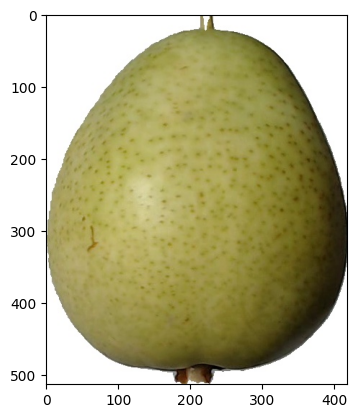

In [14]:
plt.imshow(img_list[0])
plt.show()

### Preprocessing image - UDF (option to parallelize the treatments)

In [ ]:
image_data = image_data.withColumn("path", input_file_name())

In [ ]:
# Open image with pillow library and resize of image 
def open_image(img_path, size=(20, 20)):

        img = Image.open(img_path)
        img = img.resize((20, 20))
        return img
    
# Treatment to access to S3 through boto3 librairie    
def get_path(image_path):
            image_path = image_path.replace("s3a://p8bucketimplementer/", "")
            s3 = boto3.resource(service_name='s3',
                                region_name='eu-west-3',
                                aws_access_key_id='',
                                aws_secret_access_key='')
            bucket = s3.Bucket("p8bucketimplementer")
            object = bucket.Object(img_path)
            response = object.get()
            file_stream = response['Body']
            return file_stream

In [ ]:

from pyspark.ml.feature import PCA

udf_image = udf(lambda img_path: np.asarray(open_image(get_path(image_path))).flatten().tolist())
#udf_image = pandas_udf(lambda img_path: np.asarray(open_image(get_path(image_path))).flatten().tolist(), returnType = ArrayType(DoubleType()))
spark_df = spark_df.withColumn('image', udf_image("path"))

#PCA
udf_pca = udf(lambda r: Vectors.dense(r), VectorUDT())
df = spark_df.withColumn('image', udf_pca('image'))
pca = PCA(k=99, inputCol='image', outputCol='pcaFeatures')
model_pca = pca.fit(df)
# Images transformations on the first k components
df = model_pca.transform(df)

### Prepocessing image

In [15]:
#taille de nos images 
IMG_SHAPE = (224,224,3)
resnet = ResNet50(input_shape=IMG_SHAPE, include_top=False, pooling='avg', weights='imagenet')

2022-08-24 22:36:37.150617: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


94765736/94765736 [==============================] - 1s 0us/step


In [17]:
datas =[]
for image_num in range(len(img_list)) :
    img = img_list[image_num]
    #DataFrame['text'].append(pytesseract.image_to_string(img, config = conf))
    img = cv2.resize(img, (224, 224))
    ## Expanding image dims so this represents 1 sample
    image = cv2.blur(img, (10, 10))
    img = img = np.expand_dims(img, 0)
    img = preprocess_input(img)
    extractedFeatures = resnet.predict(img)
    datas.append(extractedFeatures.flatten())

1/1 [==============================] - 0s 110ms/step


In [30]:
datas

[array([0.19906618, 0.55959225, 0.15208788, ..., 4.9296813 , 0.04261991,
        0.00623613], dtype=float32),
 array([0.5859519 , 0.24210696, 1.3616428 , ..., 0.2326281 , 0.06620861,
        0.03944245], dtype=float32),
 array([0.64448607, 0.36176562, 0.3843563 , ..., 5.769825  , 0.03311588,
        0.        ], dtype=float32)]

In [20]:
datas2 = np.asarray(datas)

## PCA

In [23]:
print("Dimensions dataset avant réduction PCA : ", datas2.shape)
pca_cnn = decomposition.PCA(n_components=0.99)
feat_pca_cnn = pca_cnn.fit_transform(datas2)
print("Dimensions dataset après réduction PCA : ", feat_pca_cnn.shape)

Dimensions dataset avant réduction PCA :  (3, 2048)
Dimensions dataset après réduction PCA :  (3, 2)


In [24]:
df = pd.DataFrame(feat_pca_cnn)

In [29]:
df

,0,1
0,-16.555853,-13.553355
1,29.652309,-1.096792
2,-13.096452,14.650155


In [25]:
# Save to csv
df.to_csv('acp.csv')

In [26]:
# Upload files to S3 bucket
s3.Bucket('p8bucketimplementer').upload_file(Filename='acp.csv', Key='acp.csv')

In [27]:
# Load csv file directly into python
obj = s3.Bucket('p8bucketimplementer').Object('acp.csv').get()
acp = pd.read_csv(obj['Body'], index_col=0)

In [28]:
acp

,0,1
0,-16.555853,-13.553355
1,29.652310,-1.096792
2,-13.096452,14.650155
